# Overview

In this notebook, I will train logistic regression model using original data (not applied DEA) for Philly county
and will use data for rejected applications only after applying DEA to retest the model. We should expect that the model will predict all these previously rejected applications to be accepted

# Data Loading

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # data visualization
import seaborn as sns # statistical data visualization
%matplotlib inline

In [2]:
df = pd.read_csv('/Users/nguyenhalinh/Desktop/Research/dataset.csv')
df = df[df['state_code'] == 'PA']
df.head()

/var/folders/vf/c31mrqv54zg80c74f5bw2__c0000gn/T/ipykernel_50068/2977462316.py:1: DtypeWarning: Columns (22,23,24,26,27,28,29,30,31,32,33,38,43,44) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/Users/nguyenhalinh/Desktop/Research/dataset.csv')


,activity_year,lei,derived_msa-md,state_code,county_code,census_tract,conforming_loan_limit,derived_loan_product_type,derived_dwelling_category,derived_ethnicity,...,denial_reason-2,denial_reason-3,denial_reason-4,tract_population,tract_minority_population_percent,ffiec_msa_md_median_family_income,tract_to_msa_income_percentage,tract_owner_occupied_units,tract_one_to_four_family_homes,tract_median_age_of_housing_units
0,2021,54930034MNPILHP25H80,14100,PA,42093.0,4.209305e+10,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,...,NaN,NaN,NaN,4686,9.80,76500,74,1035,2246,71
1,2021,54930034MNPILHP25H80,10900,PA,42095.0,4.209501e+10,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Ethnicity Not Available,...,NaN,NaN,NaN,7567,35.09,84900,78,2061,2963,64
2,2021,54930034MNPILHP25H80,39740,PA,42011.0,4.201101e+10,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,...,NaN,NaN,NaN,3040,3.39,82200,120,1032,1278,38
3,2021,54930034MNPILHP25H80,33874,PA,42091.0,4.209120e+10,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,...,NaN,NaN,NaN,4006,9.84,116300,104,1232,1319,53
4,2021,54930034MNPILHP25H80,37964,PA,42101.0,4.210103e+10,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,...,NaN,NaN,NaN,4514,98.54,67500,70,998,1677,76


In [3]:
extracted_df = df[df['action_taken'].isin([1,3])] 
extracted_df = extracted_df[extracted_df['loan_purpose'] == 1]
#clean property value column
extracted_df = extracted_df[extracted_df['property_value'].notna()]
extracted_df['property_value'] = np.where(extracted_df['property_value'] == 'Exempt',1111, extracted_df['property_value'])
extracted_df["property_value"] = pd.to_numeric(extracted_df["property_value"])
extracted_df["property_value"] = extracted_df["property_value"]/1000

extracted_df["loan_amount"] = extracted_df["loan_amount"]/1000


# clean loan terms column
extracted_df['loan_term'] = np.where(extracted_df['loan_term'] == 'Exempt',1111, extracted_df['loan_term'])
extracted_df['loan_term'] = pd.to_numeric(extracted_df['loan_term'])

#clean debt to income ratio column
extracted_df['debt_to_income_ratio'] = np.where(extracted_df['debt_to_income_ratio'] == '<20%',10, extracted_df['debt_to_income_ratio'])
extracted_df['debt_to_income_ratio'] = np.where(extracted_df['debt_to_income_ratio'] == '20%-<30%',25, extracted_df['debt_to_income_ratio'])
extracted_df['debt_to_income_ratio'] = np.where(extracted_df['debt_to_income_ratio'] == '30%-<36%',33, extracted_df['debt_to_income_ratio'])
extracted_df['debt_to_income_ratio'] = np.where(extracted_df['debt_to_income_ratio'] == '50%-60%',55, extracted_df['debt_to_income_ratio'])
extracted_df['debt_to_income_ratio'] = np.where(extracted_df['debt_to_income_ratio'] == '>60%',60, extracted_df['debt_to_income_ratio'])
extracted_df['debt_to_income_ratio'] = np.where(extracted_df['debt_to_income_ratio'] == 'Exempt',1111, extracted_df['debt_to_income_ratio'])
extracted_df["debt_to_income_ratio"] = pd.to_numeric(extracted_df["debt_to_income_ratio"])

extracted_df = extracted_df[extracted_df['property_value']!= 1111]
extracted_df = extracted_df[extracted_df['debt_to_income_ratio']!= 1111]
extracted_df = extracted_df[extracted_df['loan_term']!= 1111]

extracted_df.loc[extracted_df['action_taken'] == 1, 'outcome'] = 1
extracted_df.loc[extracted_df['action_taken'] == 3, 'outcome'] = 0

extracted_df = extracted_df[extracted_df['debt_to_income_ratio'].notna()]
extracted_df = extracted_df[extracted_df['loan_amount'].notna()]
extracted_df = extracted_df[extracted_df['income'].notna()]
extracted_df = extracted_df[extracted_df['property_value'].notna()]

In [4]:
philly_county = extracted_df[extracted_df['county_code'] == 42101]

In [5]:
philly_county = philly_county[['loan_amount', 'property_value', 'income', 'debt_to_income_ratio','outcome']].reset_index()

In [6]:
philly_county = philly_county.drop(philly_county.columns[0],axis=1)

In [7]:
philly_county.shape

(19975, 5)

## Class Distribution

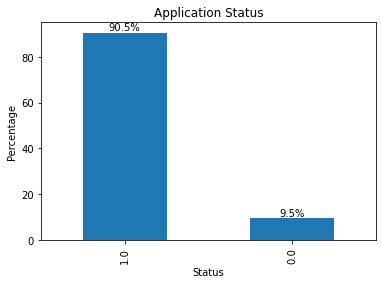

In [8]:
result_counts = philly_county['outcome'].value_counts()

# Calculate the percentages
result_pct = (result_counts / len(philly_county)) * 100

# Plotting the chart
result_pct.plot(kind='bar')

# Plotting the chart
ax = result_pct.plot(kind='bar')

# Add labels to the bars
for i, v in enumerate(result_pct):
    ax.text(i, v + 1, f'{v:.1f}%', ha='center')

plt.xlabel('Status')
plt.ylabel('Percentage')
plt.title('Application Status')

plt.show()


The chart shows that our data for Philly county is highly imbalanced

## Data Preparation

In [9]:
X = philly_county.drop(['outcome'], axis=1)

y = philly_county['outcome']

In [10]:
# split X and y into training and testing sets

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 0)

In [11]:
X_test.head()

,loan_amount,property_value,income,debt_to_income_ratio
12806,205.0,265.0,19.0,25.0
13697,175.0,185.0,57.0,55.0
19019,425.0,455.0,62.0,55.0
2255,445.0,565.0,184.0,33.0
5918,105.0,225.0,55.0,10.0


In [12]:
# check the shape of X_train and X_test

X_train.shape, X_test.shape

((11985, 4), (7990, 4))

In [13]:
# X_train.describe()

In [14]:
cols = X_train.columns
# cols

Index(['loan_amount', 'property_value', 'income', 'debt_to_income_ratio'], dtype='object')

In [15]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaledX_train = scaler.fit_transform(X_train)

scaledX_test = scaler.transform(X_test)

In [16]:
scaledX_train = pd.DataFrame(scaledX_train, columns=[cols])
scaledX_test = pd.DataFrame(scaledX_test, columns=[cols])

In [17]:
#scaledX_train.describe()

## Model Training without tuning

In [27]:
# train a logistic regression model on the training set
from sklearn.linear_model import LogisticRegression


# instantiate the model
logreg = LogisticRegression(solver='liblinear', random_state=42)


# fit the model
logreg.fit(scaledX_train, y_train)

LogisticRegression(random_state=42, solver='liblinear')

### Predicting

In [28]:
y_pred_test = logreg.predict(scaledX_test)

np.unique(y_pred_test)

array([1.])

In [29]:
# probability of getting output as 0 - rejected

logreg.predict_proba(scaledX_test)[:,0]

array([0.05123925, 0.25046292, 0.18363021, ..., 0.06290945, 0.04787176,
       0.14339919])

In [30]:
# probability of getting output as 1 - accepted

logreg.predict_proba(scaledX_test)[:,1]

array([0.94876075, 0.74953708, 0.81636979, ..., 0.93709055, 0.95212824,
       0.85660081])

### Checking accuracy score

In [31]:
from sklearn.metrics import accuracy_score

print('Model accuracy score: {0:0.4f}'. format(accuracy_score(y_test, y_pred_test)))

Model accuracy score: 0.9071


### Confusion Matrix

In [66]:
# Print the Confusion Matrix and slice it into four pieces

from sklearn.metrics import confusion_matrix, classification_report

# cm = confusion_matrix(y_test, y_pred_test)
# tn, fp, fn, tp = cm.ravel()
# print('Confusion matrix\n\n', cm)
# print('\nTrue Positives(TP) = ', tp)
# print('\nTrue Negatives(TN) = ', tn)
# print('\nFalse Positives(FP) = ', fp)
# print('\nFalse Negatives(FN) = ', fn)
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       742
         1.0       0.91      1.00      0.95      7248

    accuracy                           0.91      7990
   macro avg       0.45      0.50      0.48      7990
weighted avg       0.82      0.91      0.86      7990



/opt/anaconda3/envs/pyclass/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/pyclass/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/pyclass/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


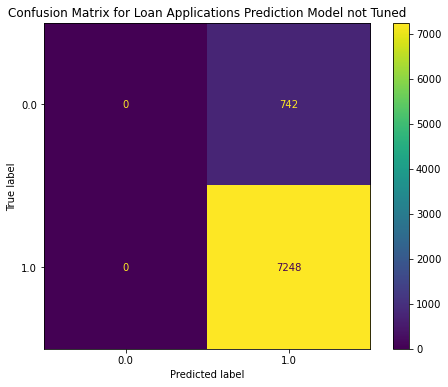

In [68]:
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred_test)

# Change figure size and increase dpi for better resolution
# and get reference to axes object
fig, ax = plt.subplots(figsize=(8,6))

# initialize using the raw 2D confusion matrix 
# and output labels (in our case, it's 0 and 1)
display = ConfusionMatrixDisplay(cm, display_labels=logreg.classes_)

# set the plot title using the axes object
ax.set(title='Confusion Matrix for Loan Applications Prediction Model not Tuned')

# show the plot. 
# Pass the parameter ax to show customizations (ex. title) 
display.plot(ax=ax);

Although the accuracy score is high, our model couldn't predict rejected application due to imbalanced classes. Thus, we need to adjust the probability threshold to tune the model

## Threshold Trial and Error

In [37]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, f1_score

model = LogisticRegression(solver='liblinear', random_state=42)
model.fit(scaledX_train,y_train)

y_pred_test = model.predict(scaledX_test)

pred_proba_df = pd.DataFrame(model.predict_proba(scaledX_test)) #Probability of the prediction
threshold_list = [0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,.7,.75,.8,.85,.9,.95,.99]
for i in threshold_list:
    print ('\n******** For i = {} ******'.format(i))
    Y_test_pred = pred_proba_df.applymap(lambda x: 1 if x>i else 0) #Dataframe with final prediction from the model
    test_accuracy = accuracy_score(y_test,Y_test_pred[1])
    f_score = f1_score(y_test,Y_test_pred[1])
    print('Testing accuracy is {}'.format(test_accuracy),'f1_score is {}'.format(f_score))
    print(confusion_matrix(y_test,Y_test_pred[1]))
    print(classification_report(y_test,Y_test_pred[1]))


******** For i = 0.05 ******
Testing accuracy is 0.907133917396746 f1_score is 0.9513059456621603
[[   0  742]
 [   0 7248]]
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       742
         1.0       0.91      1.00      0.95      7248

    accuracy                           0.91      7990
   macro avg       0.45      0.50      0.48      7990
weighted avg       0.82      0.91      0.86      7990


******** For i = 0.1 ******
Testing accuracy is 0.907133917396746 f1_score is 0.9513059456621603
[[   0  742]
 [   0 7248]]
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       742
         1.0       0.91      1.00      0.95      7248

    accuracy                           0.91      7990
   macro avg       0.45      0.50      0.48      7990
weighted avg       0.82      0.91      0.86      7990


******** For i = 0.15 ******
Testing accuracy is 0.907133917396746 f1_score is 0.9513059456621

/opt/anaconda3/envs/pyclass/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/pyclass/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/pyclass/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/e

[[   0  742]
 [   0 7248]]
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       742
         1.0       0.91      1.00      0.95      7248

    accuracy                           0.91      7990
   macro avg       0.45      0.50      0.48      7990
weighted avg       0.82      0.91      0.86      7990


******** For i = 0.35 ******
Testing accuracy is 0.907133917396746 f1_score is 0.9513059456621603
[[   0  742]
 [   0 7248]]
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       742
         1.0       0.91      1.00      0.95      7248

    accuracy                           0.91      7990
   macro avg       0.45      0.50      0.48      7990
weighted avg       0.82      0.91      0.86      7990


******** For i = 0.4 ******
Testing accuracy is 0.907133917396746 f1_score is 0.9513059456621603
[[   0  742]
 [   0 7248]]
              precision    recall  f1-score   support

         0.0 

/opt/anaconda3/envs/pyclass/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/pyclass/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/pyclass/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/e

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       742
         1.0       0.91      1.00      0.95      7248

    accuracy                           0.91      7990
   macro avg       0.45      0.50      0.48      7990
weighted avg       0.82      0.91      0.86      7990


******** For i = 0.6 ******
Testing accuracy is 0.907133917396746 f1_score is 0.9513059456621603
[[   0  742]
 [   0 7248]]
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       742
         1.0       0.91      1.00      0.95      7248

    accuracy                           0.91      7990
   macro avg       0.45      0.50      0.48      7990
weighted avg       0.82      0.91      0.86      7990


******** For i = 0.65 ******
Testing accuracy is 0.9081351689612015 f1_score is 0.9518056467498358
[[   8  734]
 [   0 7248]]
              precision    recall  f1-score   support

         0.0       1.00      0.01      

Based on this trial and error, our model performs best with threshold = 0.8

## Optimize Model with 0.8 prob threshold

In [63]:
PROB = 0.8
model = LogisticRegression(solver='liblinear', random_state=42)
model.fit(scaledX_train,y_train)
y_pred_test = model.predict(scaledX_test)
pred_proba_df = pd.DataFrame(model.predict_proba(scaledX_test))


print ('\n******** For PROB = {} ******'.format(PROB))
Y_test_pred = pred_proba_df.applymap(lambda x: 1 if x>PROB else 0)
test_accuracy = accuracy_score(y_test, y_pred_test)
print('Our testing accuracy is {}'.format(test_accuracy))
print(classification_report(Y_test_pred[1],y_test))


******** For PROB = 0.8 ******
Our testing accuracy is 0.907133917396746
              precision    recall  f1-score   support

           0       0.34      0.42      0.37       599
           1       0.95      0.93      0.94      7391

    accuracy                           0.89      7990
   macro avg       0.65      0.68      0.66      7990
weighted avg       0.91      0.89      0.90      7990



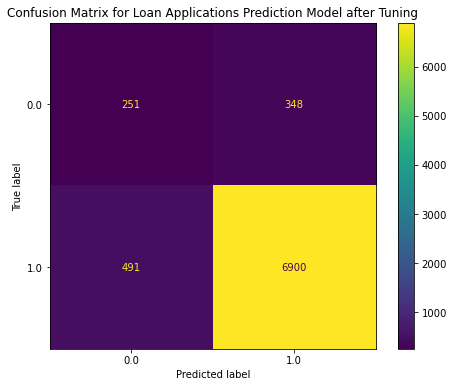

In [69]:
from sklearn.metrics import ConfusionMatrixDisplay

tuned_cm = confusion_matrix(Y_test_pred[1],y_test)

# Change figure size and increase dpi for better resolution
# and get reference to axes object
fig, ax = plt.subplots(figsize=(8,6))

# initialize using the raw 2D confusion matrix 
# and output labels (in our case, it's 0 and 1)
display = ConfusionMatrixDisplay(tuned_cm, display_labels=model.classes_)

# set the plot title using the axes object
ax.set(title='Confusion Matrix for Loan Applications Prediction Model after Tuning')

# show the plot. 
# Pass the parameter ax to show customizations (ex. title) 
display.plot(ax=ax);

## Retest Model

In [39]:
eff_df = pd.read_csv("/Users/nguyenhalinh/Desktop/Research/dea_each_county_csv/42101_county_eff.csv")

In [40]:
eff_df.head()

,Unnamed: 0,loan_amount,property_value,income,debt_to_income_ratio,outcome,DEA,eff_loan_amount,eff_property_value,eff_income,eff_debt_to_income_ratio
0,0,115.0,115.0,51.0,44.0,1.0,0.227273,189.0,210.0,51.0,10.0
1,1,145.0,145.0,43.0,39.0,1.0,0.256410,155.0,205.0,83.0,10.0
2,2,165.0,175.0,49.0,25.0,1.0,0.400000,188.8,209.4,49.0,10.0
3,3,5.0,175.0,49.0,25.0,1.0,0.400000,188.8,209.4,49.0,10.0
4,4,95.0,115.0,72.0,25.0,1.0,0.400000,190.6,216.1,72.0,10.0


In [41]:
#Drop unnecessary columns
eff_df = eff_df.drop(eff_df.columns[0],axis=1)

In [42]:
eff_df = eff_df.drop(eff_df.columns[5],axis=1)

In [43]:
eff_df.head()

,loan_amount,property_value,income,debt_to_income_ratio,outcome,eff_loan_amount,eff_property_value,eff_income,eff_debt_to_income_ratio
0,115.0,115.0,51.0,44.0,1.0,189.0,210.0,51.0,10.0
1,145.0,145.0,43.0,39.0,1.0,155.0,205.0,83.0,10.0
2,165.0,175.0,49.0,25.0,1.0,188.8,209.4,49.0,10.0
3,5.0,175.0,49.0,25.0,1.0,188.8,209.4,49.0,10.0
4,95.0,115.0,72.0,25.0,1.0,190.6,216.1,72.0,10.0


In [44]:
eff_df.dtypes

loan_amount                 float64
property_value              float64
income                      float64
debt_to_income_ratio        float64
outcome                     float64
eff_loan_amount             float64
eff_property_value          float64
eff_income                  float64
eff_debt_to_income_ratio    float64
dtype: object

In [45]:
#get original data
original_df = eff_df[eff_df.columns[:5]]

In [46]:
#get efficient (after DEA) data
new_df = eff_df[eff_df.columns[4:]]

In [47]:
#Rename columns
new_df.rename(
    columns={"eff_loan_amount": "loan_amount", "eff_property_value": "property_value", "eff_income": "income", "eff_debt_to_income_ratio":'debt_to_income_ratio'},
    inplace=True,)

/var/folders/vf/c31mrqv54zg80c74f5bw2__c0000gn/T/ipykernel_50068/1578343534.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.rename(


In [48]:
#only selected rejected applications
new_df = new_df[new_df['outcome']==0]

In [49]:
new_df.head()

,outcome,loan_amount,property_value,income,debt_to_income_ratio
9,0.0,285.0,417.3,526.7,10.0
17,0.0,335.0,477.5,539.8,10.0
27,0.0,192.7,224.1,99.0,10.0
51,0.0,192.4,222.9,95.0,10.0
75,0.0,265.0,393.2,521.5,10.0


### Data Preparation

In [50]:
newX_test = new_df.drop(['outcome'], axis=1)
newy_test = new_df['outcome']

In [51]:
#scale features
new_scaledX_test = scaler.fit_transform(newX_test)
new_scaledX_test = pd.DataFrame(new_scaledX_test, columns=[cols])

In [52]:
PROB = 0.8
new_y_pred_test = model.predict(new_scaledX_test)
new_pred_proba_df = pd.DataFrame(model.predict_proba(new_scaledX_test))

print ('\n******** For PROB = {} ******'.format(PROB))
new_Y_test_pred = new_pred_proba_df.applymap(lambda x: 1 if x>PROB else 0)
new_test_accuracy = accuracy_score(newy_test, new_Y_test_pred[new_Y_test_pred.columns[1:]])
print('Our testing accuracy is {}'.format(new_test_accuracy))
print(confusion_matrix(newy_test,new_Y_test_pred[new_Y_test_pred.columns[1:]]))


******** For PROB = 0.8 ******
Our testing accuracy is 0.0
[[   0 1897]
 [   0    0]]


In [53]:
new_cm = confusion_matrix(newy_test, new_y_pred_test)

tn, fp, fn, tp = new_cm.ravel()
print('Confusion matrix\n\n', new_cm)

print('\nTrue Positives(TP) = ', tp)

print('\nTrue Negatives(TN) = ', tn)

print('\nFalse Positives(FP) = ', fp)

print('\nFalse Negatives(FN) = ', fn)

Confusion matrix

 [[   0 1897]
 [   0    0]]

True Positives(TP) =  0

True Negatives(TN) =  0

False Positives(FP) =  1897

False Negatives(FN) =  0


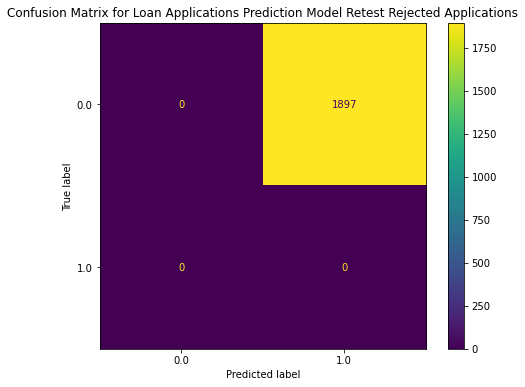

In [70]:

# Change figure size and increase dpi for better resolution
# and get reference to axes object
fig, ax = plt.subplots(figsize=(8,6))

# initialize using the raw 2D confusion matrix 
# and output labels (in our case, it's 0 and 1)
display = ConfusionMatrixDisplay(new_cm, display_labels=model.classes_)

# set the plot title using the axes object
ax.set(title='Confusion Matrix for Loan Applications Prediction Model Retest Rejected Applications')

# show the plot. 
# Pass the parameter ax to show customizations (ex. title) 
display.plot(ax=ax);

As expected, all the rejected applications after being optimized with DEA are now predicted as accepted by logistic regression model